In [ ]:
#CLIP with FAISS

In [68]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from datasets import load_dataset
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [16]:
pip install faiss-cpu

In [17]:
import faiss


In [18]:
dataset = load_dataset("beans", split="train")
beans_images = list(dataset["image"])  

model, preprocess, _ = open_clip.create_model_and_transforms("ViT-B/32", pretrained="openai")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:380: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [19]:
def encode_image(image):
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.encode_image(image)
    return features.squeeze(0).cpu().numpy()

beans_embeddings = np.array([encode_image(img) for img in beans_images])
beans_embeddings = beans_embeddings / np.linalg.norm(beans_embeddings, axis=1, keepdims=True)

  #image = preprocess(image).unsqueeze(0).to(device)
Preprocesses the image using preprocess(image), which applies transformations required by the CLIP model.
Adds a batch dimension using .unsqueeze(0) because PyTorch models expect batched inputs.
Moves the image tensor to the correct device (CPU or GPU).

  #with torch.no_grad():
Disables gradient calculations to save memory and speed up inference since we don't need to backpropagate.

   #features = model.encode_image(image)
Passes the image through the CLIP model to get its feature representation (embedding)

   #return features.squeeze(0).cpu().numpy()
Removes the batch dimension (squeeze(0)) to return a single feature vector.
Moves the tensor to the CPU (cpu()) to ensure compatibility with NumPy.
Converts the tensor to a NumPy array (numpy()) for further processing.



encode_image(img): Applies the encode_image function to all images in the beans_images list, generating embeddings for each image.

beans_embeddings / np.linalg.norm(beans_embeddings, axis=1, keepdims=True): Normalizes the embeddings to unit vectors. This ensures that similarity is based purely on the direction of the vector, not its magnitude.

In [20]:
d = beans_embeddings.shape[1]  
index = faiss.IndexFlatIP(d)   
index.add(beans_embeddings)

d = beans_embeddings.shape[1]: Gets the dimensionality of the embeddings (i.e., the number of features per image).

faiss.IndexFlatIP(d): Creates a FAISS index that performs an inner product (dot product) search, which is equivalent to cosine similarity if the vectors are normalized.

index.add(beans_embeddings): Adds the image embeddings to the FAISS index, preparing it for fast similarity search.



Top 5 similar images for Query Index 10:
Match 1: Image Index 681 | Similarity Score: 0.9426
Match 2: Image Index 354 | Similarity Score: 0.9421
Match 3: Image Index 436 | Similarity Score: 0.9414
Match 4: Image Index 675 | Similarity Score: 0.9365
Match 5: Image Index 604 | Similarity Score: 0.9326


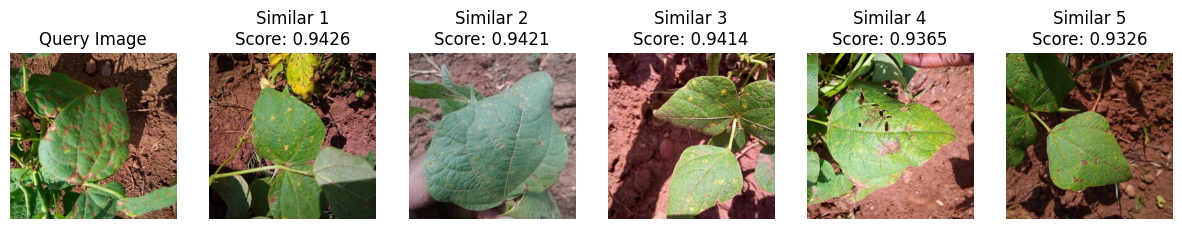

In [22]:
def find_similar_images(query_idx, top_k=5):
    query_embedding = beans_embeddings[query_idx].reshape(1, -1)
    scores, indices = index.search(query_embedding, top_k + 1)  # Retrieve top K+1 (including self-match)

    # Remove self-match (query image)
    indices = indices[0][1:]
    scores = scores[0][1:]

    print(f"\nTop {top_k} similar images for Query Index {query_idx}:")
    for rank, (idx, score) in enumerate(zip(indices, scores)):
        print(f"Match {rank+1}: Image Index {idx} | Similarity Score: {score:.4f}")

    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 3))

    #plotting query image
    axes[0].imshow(np.array(beans_images[query_idx].convert("RGB")))
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    #plotting top 5 image
    for i, idx in enumerate(indices):
        axes[i + 1].imshow(np.array(beans_images[idx].convert("RGB")))
        axes[i + 1].set_title(f"Similar {i+1}\nScore: {scores[i]:.4f}")
        axes[i + 1].axis("off")

    plt.show()

find_similar_images(query_idx=10, top_k=5)


find_similar_images(query_idx, top_k=5): This function finds the top k most similar images to a given query image

query_embedding = beans_embeddings[query_idx].reshape(1, -1): Retrieves the embedding for the query image and reshapes it to match FAISS input requirements.

index.search(query_embedding, top_k + 1): Searches the FAISS index for the top k+1 nearest neighbors (including the query image itself).

Remove self-match: The query image will always be the first match, so we remove it from the results.
Plotting: Uses matplotlib to plot the query image and the top k similar images side by side.


In [ ]:
#SIFT with KNN

In [23]:
import cv2
dataset = load_dataset("beans", split="train")
beans_images = [np.array(img.convert("RGB")) for img in dataset["image"]]  


In [24]:
sift = cv2.SIFT_create()

# Function to extract SIFT features
def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    keypoints, descriptors = sift.detectAndCompute(gray, None)  
    return descriptors


cv2.SIFT_create(): Initializes the SIFT (Scale-Invariant Feature Transform) feature extractor, which detects and computes local keypoints and descriptors in an image.

extract_sift_features(image): A function that:
    Converts the image to grayscale (cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)) because SIFT works on single-channel images.
    sift.detectAndCompute: Detects keypoints in the image and computes the corresponding feature descriptors (numerical representations) for each keypoint.


In [25]:
sift_descriptors = [extract_sift_features(img) for img in beans_images]
valid_indices = [i for i, desc in enumerate(sift_descriptors) if desc is not None]
sift_descriptors = [sift_descriptors[i] for i in valid_indices]
beans_images = [beans_images[i] for i in valid_indices]

sift_descriptors: Applies the extract_sift_features function to each image, resulting in a list of feature descriptors for each image.

valid_indices: Filters out any images for which no descriptors were found (i.e., desc is None).

sift_descriptors and beans_images: Updates both lists to only include images that successfully had SIFT descriptors computed.


In [26]:
num_clusters = 10
bow_trainer = cv2.BOWKMeansTrainer(num_clusters)

for desc in sift_descriptors:
    bow_trainer.add(desc)
vocabulary = bow_trainer.cluster()

1) SIFT generates a large number of local feature descriptors for each image, each one high-dimensional. These descriptors represent specific patterns or keypoints in the image.
2) However, these descriptors are not directly comparable across images in their raw form. To make the descriptors more manageable and to create a fixed-length representation of an image, BoW is used.
BoW groups these high-dimensional feature descriptors (SIFT descriptors) into visual words, which are the cluster centers (or centroids) obtained by clustering the descriptors using algorithms like K-means.
3) By converting the descriptors into "words" (cluster centers), each image is represented as a histogram of the occurrences of these visual words. This simplifies the representation of the image, reducing the complexity.

While it’s possible to match SIFT descriptors directly (using nearest neighbor search, for example), this approach requires comparing each descriptor of one image with all descriptors of another, which is computationally expensive, especially when the dataset grows.

num_clusters = 10: Defines the number of clusters in the visual vocabulary. This means we will group the descriptors into 10 clusters.

cv2.BOWKMeansTrainer(num_clusters): Initializes a Bag-of-Words (BoW) trainer using K-means clustering. This method will group the SIFT descriptors into num_clusters clusters.

bow_trainer.add(desc): Adds each image’s SIFT descriptors to the BoW trainer.

vocabulary = bow_trainer.cluster(): Performs the K-means clustering to create a "vocabulary" of visual words (cluster centers). Each cluster center represents a typical feature pattern found in the images.

In [28]:
from scipy.cluster.vq import vq

def compute_bow_feature(image):
    desc = extract_sift_features(image)
    if desc is None:
        return np.zeros((num_clusters,))

    words, _ = vq(desc, vocabulary)  # Assign descriptors to nearest cluster center
    bow_histogram = np.zeros((num_clusters,))
    for w in words:
        bow_histogram[w] += 1  # Count occurrences of each cluster
    return bow_histogram

bow_features = np.array([compute_bow_feature(img) for img in beans_images])
bow_features = bow_features / np.linalg.norm(bow_features, axis=1, keepdims=True)

scipy.cluster.vq.vq: This function is used to quantize (i.e., assign) the descriptors to their closest visual word (cluster center).

compute_bow_feature(image): A function that:
    a) Extracts the SIFT descriptors from an image.
    b) vq(desc, vocabulary): Assigns each descriptor to the closest visual word in the vocabulary.
    c) bow_histogram: Creates a histogram of visual word occurrences (i.e., counts how many times each cluster center is represented in the image's descriptors).
    d) The result is a Bag-of-Words (BoW) feature for the image, which is a vector of length equal to the number of clusters (10 in this case). Each entry in this vector counts how often each cluster is present in the image.

bow_features: Computes the BoW features for all images in the dataset.

bow_features / np.linalg.norm(bow_features, axis=1, keepdims=True): Normalizes the BoW features to unit vectors, ensuring that the similarity calculations will focus on the relative frequency of words, not their absolute counts.

In [30]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5, metric="euclidean")
knn.fit(bow_features)


NearestNeighbors(metric='euclidean')


Top 5 similar images for Query Index 555:
Match 1: Image Index 448 | Distance: 0.1103
Match 2: Image Index 625 | Distance: 0.1195
Match 3: Image Index 481 | Distance: 0.1272
Match 4: Image Index 140 | Distance: 0.1364
Match 5: Image Index 488 | Distance: 0.1451


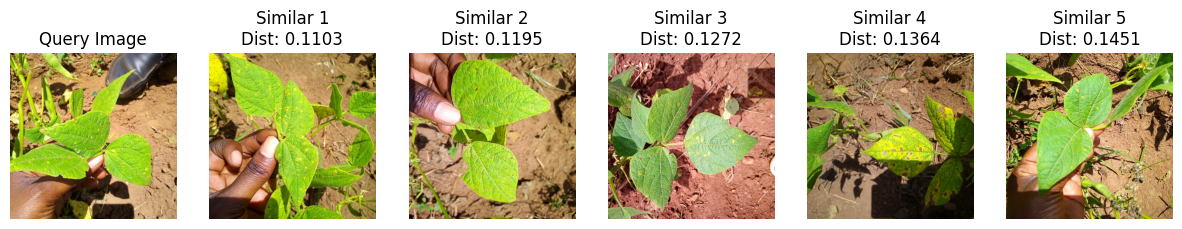

In [32]:
def find_similar_images(query_idx, top_k=5):
    query_feature = bow_features[query_idx].reshape(1, -1)  # Reshape for KNN search
    distances, indices = knn.kneighbors(query_feature, n_neighbors=top_k + 1)

    indices = indices[0][1:]
    distances = distances[0][1:]

    print(f"\nTop {top_k} similar images for Query Index {query_idx}:")
    for rank, (idx, dist) in enumerate(zip(indices, distances)):
        print(f"Match {rank+1}: Image Index {idx} | Distance: {dist:.4f}")

    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 3))
    axes[0].imshow(beans_images[query_idx])
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    for i, idx in enumerate(indices):
        axes[i + 1].imshow(beans_images[idx])
        axes[i + 1].set_title(f"Similar {i+1}\nDist: {distances[i]:.4f}")
        axes[i + 1].axis("off")

    plt.show()
find_similar_images(query_idx=555, top_k=5)

In [ ]:
#RESNET with KNN

In [54]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image


In [55]:
dataset = load_dataset("beans", split="train")
beans_images = [np.array(img.convert("RGB")) for img in dataset["image"]]

In [56]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms.Compose(): A function that chains multiple image transformations together into a single operation.

RandomResizedCrop(224): Randomly crops the image to 224x224 pixels, and resizes it to maintain a consistent size for input to the model.

RandomHorizontalFlip(): Randomly flips the image horizontally with a probability of 50%. This is an augmentation technique to help the model generalize better.

ColorJitter(): Randomly changes the brightness, contrast, saturation, and hue of the image. This is another data augmentation technique that adds variability to the dataset.

ToTensor(): Converts the image into a tensor, which is the format PyTorch models expect for input.

Normalize(): Normalizes the image tensor by subtracting the mean and dividing by the standard deviation for each channel (RGB). These values are commonly used for models pre-trained on ImageNet.

In [57]:
resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1]) 
resnet.eval() 


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

models.resnet18(pretrained=True): Loads the pre-trained ResNet-18 model, which has been trained on the ImageNet dataset. ResNet-18 is a type of Convolutional Neural Network (CNN) known for its residual connections, which help to prevent the vanishing gradient problem.

nn.Sequential(*list(resnet.children())[:-1]): The original ResNet model consists of several layers, including a final fully connected layer that outputs class probabilities. To use it for feature extraction, we remove this last layer ([:-1]) and keep all layers up to the second-last one. This will allow us to extract the feature map (the penultimate layer) instead of class predictions.

resnet.eval(): Sets the model to evaluation mode. In this mode, layers like dropout and batch normalization behave differently than during training, making the model more stable for inference.


In [58]:
def extract_resnet_features(image):
    image = transform(image).unsqueeze(0)  
    with torch.no_grad():  
        features = resnet(image)  # Get features from the model
    return features.squeeze().numpy() 

resnet_features = []
for img in beans_images:
    # Make sure image is in PIL format before processing
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    features = extract_resnet_features(img)
    resnet_features.append(features)

resnet_features = np.vstack(resnet_features)
resnet_features = resnet_features / np.linalg.norm(resnet_features, axis=1, keepdims=True)

extract_resnet_features(image): A function that extracts features from a single image.
    a) transform(image): Applies the transformation pipeline to the input image, including resizing, flipping, color jitter, and normalization.
    b) unsqueeze(0): Adds a batch dimension to the image tensor (since the model expects a batch of images, even if there's just one image).
    c) torch.no_grad(): Disables gradient calculation, which is not needed for inference. This reduces memory usage and computation time.
    d) resnet(image): Passes the image through the ResNet model to obtain the feature map from the second-to-last layer.
    e) squeeze(): Removes the batch dimension, as the model output is a 2D tensor with shape (1, feature_size). We only need the features, so we squeeze the output to a 1D array.
    f) numpy(): Converts the PyTorch tensor to a NumPy array, which is easier to work with for further computations.



resnet_features = []: Initializes an empty list to store the features for all images.
for img in beans_images: Loops over all images in the beans_images list.
    a) if isinstance(img, np.ndarray): Checks if the image is in NumPy array format (it may be from a previous transformation).
    b) Image.fromarray(img): Converts the NumPy array back to a PIL image if necessary.
    c) extract_resnet_features(img): Calls the function to extract features from the current image.
    d) resnet_features.append(features): Appends the extracted features to the resnet_features list.



np.vstack(resnet_features): Stacks all feature vectors vertically into a single 2D NumPy array, where each row represents the feature vector of one image.

np.linalg.norm(resnet_features, axis=1, keepdims=True): Computes the L2 norm (Euclidean norm) of each row (feature vector) in the array. This step normalizes the feature vectors so that each vector has a length of 1.

resnet_features / np.linalg.norm(...): Divides each feature vector by its L2 norm, normalizing all vectors.

In [59]:
knn = NearestNeighbors(n_neighbors=5, metric="cosine")  
knn.fit(resnet_features)


NearestNeighbors(metric='cosine')


Top 5 similar images for Query Index 1000:
Match 1: Image Index 774 | Cosine Distance: 0.1479
Match 2: Image Index 912 | Cosine Distance: 0.1480
Match 3: Image Index 540 | Cosine Distance: 0.1499
Match 4: Image Index 847 | Cosine Distance: 0.1560
Match 5: Image Index 840 | Cosine Distance: 0.1561


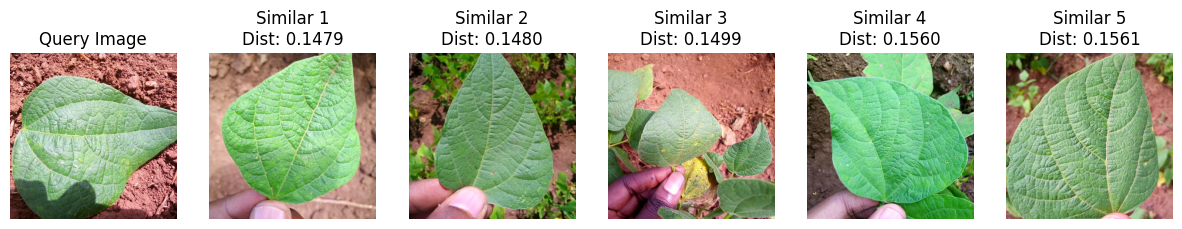

In [64]:
def find_similar_images(query_idx, top_k=5):
    query_feature = resnet_features[query_idx].reshape(1, -1)  
    distances, indices = knn.kneighbors(query_feature, n_neighbors=top_k + 1)

    # Remove self-match
    indices = indices[0][1:]
    distances = distances[0][1:]

    print(f"\nTop {top_k} similar images for Query Index {query_idx}:")
    for rank, (idx, dist) in enumerate(zip(indices, distances)):
        print(f"Match {rank+1}: Image Index {idx} | Cosine Distance: {dist:.4f}")

    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 3))
    axes[0].imshow(beans_images[query_idx])
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    for i, idx in enumerate(indices):
        axes[i + 1].imshow(beans_images[idx])
        axes[i + 1].set_title(f"Similar {i+1}\nDist: {distances[i]:.4f}")
        axes[i + 1].axis("off")

    plt.show()

find_similar_images(query_idx=1000, top_k=5)